# ARIMA models analysis using RNN and LSTM

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as scs

from keras.models import Sequential
from keras.layers import Dense, RNN
# my utils library
from ts_utils import stationary_check, tsplot

plt.rcParams['figure.figsize'] = 15, 8

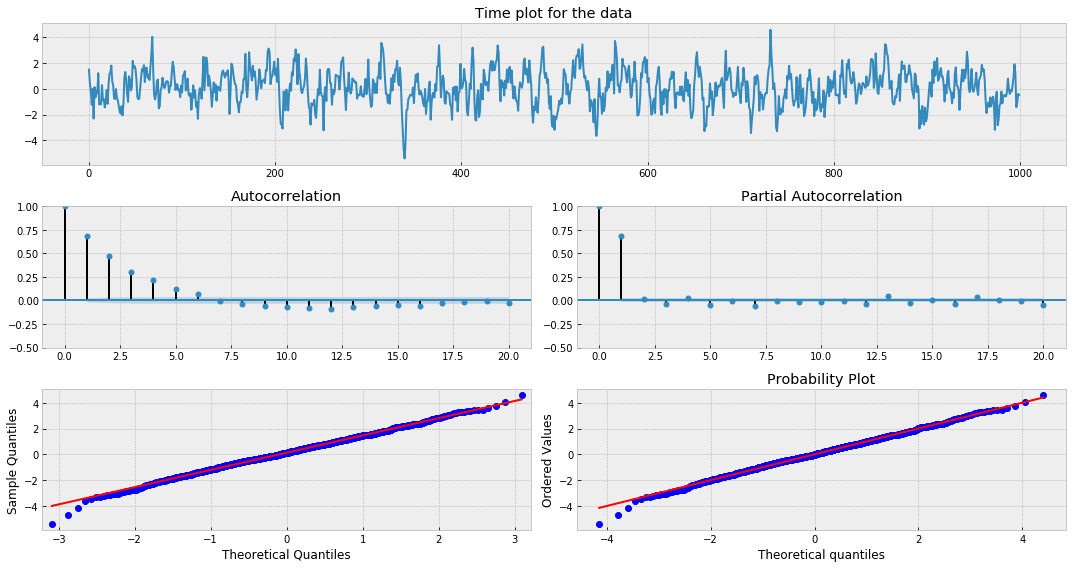

In [22]:
np.random.seed(1)
n_samples = 1000
data = noise = np.random.normal(size=1000)

# ar(1) model : x[t] = alpha * x[t-1] + noise

# case : 1, alpha = 0.5
alpha = 0.7
for t in range(len(data)):
    data[t] = alpha * data[t-1] + noise[t]

tsplot(data, lags=20, show=True)

In [46]:
def train_test_split(data, fraction=0.7):
    training = int(len(data)*fraction)
    train = data[0:training, 0].reshape(-1, 1)
    test = data[training:, 0].reshape(-1, 1)
    return train, test


def prepare_data(data, time_step=1):
    dataX = []
    dataY = []
    for i in range(len(data)-time_step-1):
        temp = data[i:(i+time_step), 0]
        dataX.append(temp)
        dataY.append(data[i+time_step, 0])
    return np.array(dataX), np.array(dataY).reshape(-1, 1)

In [47]:
data = data.reshape(-1, 1)
print(data.shape)

(1000, 1)


In [48]:
# split the data into train and test samples
train, test = train_test_split(data, fraction=0.7)
print(len(train))
print(len(test))
print(train.shape)
print(test.shape)

700
300
(700, 1)
(300, 1)


In [49]:
# prepare the uni-variate data in the form of X, y
trainX, trainY = prepare_data(train, time_step=1)
testX, testY = prepare_data(test, time_step=1)

print(trainX.shape)
print(trainY.shape)

(698, 1)
(698, 1)


In [50]:
# create LSTM model
time_step = 1
features = 1

# reshape the input in the form of [#samples, time step, features]
trainX = np.reshape(trainX, (trainX.shape[0], time_step, features))
testX = np.reshape(testX, (testX.shape[0], time_step, features))

In [52]:
from keras.models import Model
from keras.layers import Input

In [54]:
input_ = Input(shape=(1, 1))
rnn1, rnn_c, output = RNN(3, return_sequences=True, return_state=True)(input_)

model = Model(inputs=input_, output=[rnn1, rnn_c, output])
model.summary()

ValueError: ('`cell` should have a `call` method. The RNN was passed:', 3)

In [ ]:
# training and model fitting
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(trainX, trainY, batch_size=1, epochs=100, verbose=2)